# ResNet152 Architecture

In [1]:
import torch
import torch.nn as nn

In [2]:
class block(nn.Module):
  # Identity downsample for conv layer for projection shortcut
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(block,self).__init__()
    self.expansion = 4

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

    self.relu = nn.ReLU()

    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

In [3]:
class ResNet(nn.Module):
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64 # Since, in resnet the input channel starts from 64

    # For Conv1 (image_channels in start is 3(RGB) --> after conv layer 64)
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()

    # For Maxpool (channel 64 remains constant, spatial dimension decreases in half)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet layers (In ResNet152, there are 4 layers where, in each layer the blocks are repeated [3,8,36,3] times)
    self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
    self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
    self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

    # For Avg. Pooling such that the output is 2048x1x1 so Adaptive Pooling applied accordingly
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    # For final fully connected layer
    self.fc = nn.Linear(2048*1*1, num_classes)

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc(x)
    return x

  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride!=1 or self.in_channels != out_channels*4 :
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                    stride=stride),
                                          nn.BatchNorm2d(out_channels*4))

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels*4

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

In [4]:
def ResNet152(image_channels=3, num_classes=3):
  return ResNet(block, [3,8,36,3], image_channels, num_classes)

In [5]:
# Instantiate ResNet101
model = ResNet152()

In [6]:
# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Model summary to compare params
from torchsummary import summary

summary(model.to(device), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,

# Load Cifar10 dataset

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations to apply to the CIFAR-10 data
transform = transforms.Compose([transforms.Resize((224,224)), #<-- Resize for ResNet input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Download and load train and test data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:13<00:00, 12923919.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Filtered dataset

In [9]:
# Filter images from specific labels
desired_labels = [0, 1, 2]  # Airplane, Automobile, Bird
filtered_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] in desired_labels]
filtered_dataset = torch.utils.data.Subset(train_dataset, filtered_indices)

# Save the filtered dataset locally
save_path = "./filtered_dataset.pth"
torch.save(filtered_dataset, save_path)

print("Filtered dataset saved at:", save_path)


Filtered dataset saved at: ./filtered_dataset.pth


In [10]:
# Random split filtered dataset
from torch.utils.data import random_split

# Define the proportions for train and test split
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the sizes for train and test datasets
train_size = int(train_ratio * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size

# Split the dataset into train and test subsets
train_dataset, test_dataset = random_split(filtered_dataset, [train_size, test_size])

# Verify the sizes of the train and test datasets
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 12000
Test dataset size: 3000


# DataLoader

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [12]:
# Example from train_loader
train_iterate = iter(train_loader)
features, labels = next(train_iterate)
features.shape

torch.Size([8, 3, 224, 224])

In [13]:
labels

tensor([2, 0, 2, 1, 0, 1, 0, 0])

# Train on filtered Dataset

In [14]:
# Instantiate model
model_train = ResNet152(num_classes=3)

In [15]:
# Pass model to device
model_train = model_train.to(device)


In [16]:
# Compile the model
# Define the optimizer
optimizer = torch.optim.Adam(model_train.parameters(), lr=0.0001) # Decrease the lr, because batch normalization

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [17]:
from tqdm import tqdm
import time

num_epochs = 10 # For less computation

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model_train.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_train(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Update running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1) # the maximum value and the index of that maximum value along dimension 1
        running_corrects += torch.sum(preds == labels.data) # labels.data gives access to underlying labels tensor

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Calculate epoch loss and accuracy for training data
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Print the loss and accuracy for training and validation data
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")


Epochs:  10%|█         | 1/10 [06:45<1:00:49, 405.55s/it]

Epoch 1 completed in 405.54 seconds
Epoch [1/10], Train Loss: 0.7714, Train Accuracy: 0.6669


Epochs:  20%|██        | 2/10 [13:31<54:04, 405.56s/it]  

Epoch 2 completed in 405.55 seconds
Epoch [2/10], Train Loss: 0.5676, Train Accuracy: 0.7685


Epochs:  30%|███       | 3/10 [20:16<47:18, 405.54s/it]

Epoch 3 completed in 405.50 seconds
Epoch [3/10], Train Loss: 0.4847, Train Accuracy: 0.8057


Epochs:  40%|████      | 4/10 [27:02<40:32, 405.49s/it]

Epoch 4 completed in 405.41 seconds
Epoch [4/10], Train Loss: 0.4375, Train Accuracy: 0.8249


Epochs:  50%|█████     | 5/10 [33:46<33:45, 405.14s/it]

Epoch 5 completed in 404.49 seconds
Epoch [5/10], Train Loss: 0.3814, Train Accuracy: 0.8492


Epochs:  60%|██████    | 6/10 [40:30<26:59, 404.90s/it]

Epoch 6 completed in 404.43 seconds
Epoch [6/10], Train Loss: 0.3471, Train Accuracy: 0.8618


Epochs:  70%|███████   | 7/10 [47:15<20:14, 404.67s/it]

Epoch 7 completed in 404.18 seconds
Epoch [7/10], Train Loss: 0.3010, Train Accuracy: 0.8842


Epochs:  80%|████████  | 8/10 [53:56<13:27, 403.56s/it]

Epoch 8 completed in 401.17 seconds
Epoch [8/10], Train Loss: 0.2740, Train Accuracy: 0.8945


Epochs:  90%|█████████ | 9/10 [1:00:37<06:42, 402.78s/it]

Epoch 9 completed in 401.05 seconds
Epoch [9/10], Train Loss: 0.2459, Train Accuracy: 0.9085


Epochs: 100%|██████████| 10/10 [1:07:18<00:00, 403.85s/it]

Epoch 10 completed in 401.09 seconds
Epoch [10/10], Train Loss: 0.2233, Train Accuracy: 0.9135


In [18]:
correct = 0
total = 0

with torch.no_grad(): # Disabling gradient calculation, since testing doesnot require weight update
    model_train.eval() # Set the model to evaluation mode

    for inputs, labels in test_loader:
      # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_train(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 91.43%


In [19]:
# Save the trained model
save_path = "ResNet152.pth"
torch.save(model_train.state_dict(), save_path)

print("Trained model saved at:", save_path)

Trained model saved at: ResNet152.pth


# Inference

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet152(3,3)
    model.load_state_dict(torch.load("/content/ResNet152.pth")) # Load the model
    model.eval()
    model = model.to(device)

    transform = transforms.Compose([transforms.Resize((224,224)), #<-- Resize for ResNet input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    input_image = transform(image).unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        input_image = input_image.to(device)
        output = model(input_image)

    _, predicted = torch.max(output.data, 1)

    # Get the predicted class probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]

    # Get the predicted class label
    predicted_class = torch.argmax(probabilities).item()

    return probabilities, predicted_class


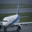

Predicted class: airplane
Probability: 0.570580780506134


In [21]:
# Test on airplane
image_path = "/content/airplane.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

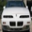

Predicted class: automobile
Probability: 0.9958659410476685


In [22]:
# Test on automobile
image_path = "/content/automobile.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

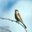

Predicted class: bird
Probability: 0.8240367770195007


In [23]:
# Test on automobile
image_path = "/content/bird.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())